In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import scipy.stats as sciStat
import time

import sussix

# Creating dummy signal
#==============================================
N  = np.arange(int(1e5))
Q0 = 0.31025793875089835
Qs = 0.002
dQ = Qs/12
Jx = (0.5*(10**2))

n_bands_Qs = 1
n_bands_dQ = 5
i,j    = np.arange(-n_bands_dQ,n_bands_dQ+1),np.arange(-n_bands_Qs,n_bands_Qs+1)
Ai,Aj  = sciStat.cauchy.pdf(i/np.max(i),0,0.05),sciStat.cauchy.pdf(j/np.max(j),0,0.05)
Ai,Aj  = Ai/np.max(Ai),Aj/np.max(Aj)

amplitudes  = np.array([[ (np.sqrt(2*Jx)*_Ai*_Aj) for _i,_Ai in zip(i,Ai) ] for _j,_Aj in zip(j,Aj) ]).flatten()
frequencies = np.array([[Q0+ _j*Qs + _i*dQ for _i,_Ai in zip(i,Ai) ] for _j,_Aj in zip(j,Aj) ]).flatten() 

expected = pd.DataFrame({'amplitude':amplitudes,'frequency':frequencies})
expected.sort_values(by='amplitude',ascending=False,inplace=True)
expected.reset_index(drop=True,inplace=True)

x,px    = sussix.analysis.generate_signal(expected.amplitude,expected.frequency,N)
#==============================================

def get_FFT(x):
    x     = np.array(x)
    turns = np.arange(len(x))

    # Cropping signal to closest power of 2
    Nt      = len(x)
    crop_at = 2**int(np.log2(Nt))



    
    spectrum = np.fft.fft(x[:crop_at])
    freq     = np.fft.fftfreq(turns[:crop_at].shape[-1])

    idx      = np.argmax(np.abs(spectrum))
    Qx       = freq[idx]
    return freq[freq>0],np.abs(spectrum)[freq>0]

---
# SUSSIX
---

In [2]:
# Computing FFT
freq,spectrum = get_FFT(x)

# Computing frequencies and amplitudes with SUSSIX
#=================================================
results = sussix.get_spectrum( x, px, number_of_harmonics = len(expected),Hann_order = 1)
#=================================================


--- 
# Plotting
---

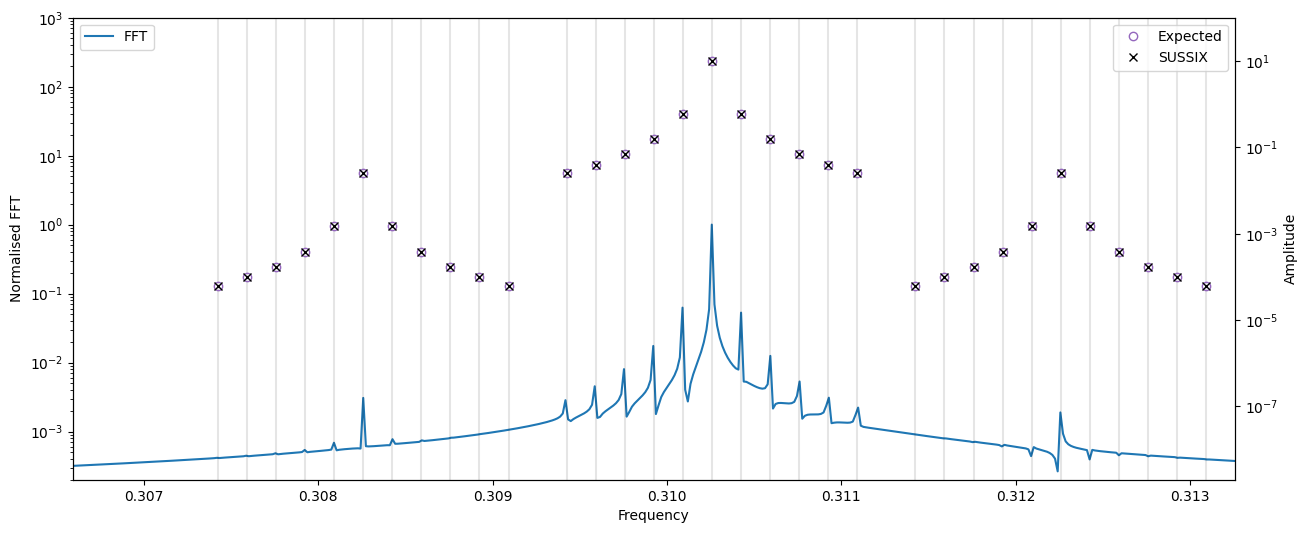

In [3]:
plt.figure(figsize=(15,6))
plt.plot(freq,spectrum/np.max(spectrum),'-',label='FFT')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Normalised FFT')
plt.legend(loc='upper left')
plt.ylim(2e-4,1e3)


ax2 = plt.gca().twinx()
plt.plot(expected.frequency,expected.amplitude,'o',color='C4',alpha=1,mfc='none',label='Expected')
plt.plot(results.frequency,np.abs(results.amplitude),'x',color='k',alpha=1,mfc='none',label='SUSSIX')

plt.yscale('log')
plt.ylabel('Amplitude')

plt.xlim(Q0-10*Qs,Q0+10*Qs)
plt.xlim(expected.frequency.min()-5*dQ,expected.frequency.max()+dQ)
for line in expected.frequency:
    plt.axvline(line,color='k',alpha=0.1,zorder=-10)

plt.ylim(2e-9,1e2)

plt.legend(loc='upper right')